# Data download

In [30]:
! wget http://hgdownload.cse.ucsc.edu/goldenpath/hg19/database/cpgIslandExt.txt.gz
! gunzip cpgIslandExt.txt.gz
! wget http://hgdownload.soe.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeHaibMethyl450/wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed.gz
! wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes

--2019-11-17 23:05:13--  http://hgdownload.cse.ucsc.edu/goldenpath/hg19/database/cpgIslandExt.txt.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 646179 (631K) [application/x-gzip]
Saving to: ‘cpgIslandExt.txt.gz’

cpgIslandExt.txt.gz 100%[===================>] 631,03K   107KB/s    in 6,1s    

2019-11-17 23:05:19 (104 KB/s) - ‘cpgIslandExt.txt.gz’ saved [646179/646179]

--2019-11-17 23:05:20--  http://hgdownload.soe.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeHaibMethyl450/wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9038203 (8,6M) [application/x-gzip]
Saving to: ‘wgEncod

# Imports

In [111]:
%matplotlib inline
from pybedtools import BedTool
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Task 1

In [112]:
class DNASequence:
    def __init__(self):
        self.chromosomes = dict()
    
    def __str__(self):
        return '\n'.join([str(r) for r in self._sequence])
    
    def __len__(self):
        return len(self._sequence)
    
    def __getitem__(self, ind):
        return self._sequence[ind]
    
    def get_coordinate_region(self, coordinate):
        seq = self.chromosomes[coordinate.chromosome]
        for r in seq:
            if r.contains(coordinate.coordinate):
                return r.variety
        print(seq[len(seq) - 1])
        print(coordinate)
        raise KeyError()
        
    def append(self, chromosome_range):
        if chromosome_range.has_valid_range():
            if chromosome_range.chromosome not in self.chromosomes.keys():
                self.chromosomes[chromosome_range.chromosome] = list()
            self.chromosomes[chromosome_range.chromosome].append(chromosome_range)
            
    def extend(self, chromosome_ranges):
        for chromosome_range in chromosome_ranges:
            self.append(chromosome_range)
            

class ChromosomeRange:
    def __init__(self, variety, chromosome, start, stop):
        self.variety = variety
        self.chromosome = chromosome
        self.start = start
        self.stop = stop
        
    def __repr__(self):
        return f'ChromosomeRange<variety: {self.variety}, chromosome: {self.chromosome} start:{self.start}, stop:{self.stop}'
        
    def __str__(self):
        return f'{self.variety} of {self.chromosome} in range ({self.start}, {self.stop})'
    
    def has_valid_range(self):
        return self.start < self.stop
    
    def contains(self, x):
        return self.start <= x and self.stop >= x
    
    def to_dict(self):
        return {
            'variety': self.variety,
            'chromosome': self.chromosome,
            'start': self.start,
            'stop': self.stop
        }
    
    @classmethod
    def from_dict(cls, row):
        return cls(
            variety = 'CpG island',
            chromosome = row['chromosome'],
            start = row['start'],
            stop = row['stop']    
        )
    
class ChromosomeCoordinate:
    def __init__(self, chromosome, coordinate):
        self.chromosome = chromosome
        self.coordinate = coordinate
        
    def __repr__(self):
        return f'ChromosomeCoordinate(chromosome={self.chromosome}, coordinate={self.coordinate})'
    
    def __str__(self):
        return f'Chromosome={self.chromosome}, Coordinate: {self.coordinate}'
    
    @classmethod
    def from_dict(cls, dct):
        return cls(dct['chromosome'], dct['coordinate'])

def get_begin_ranges(cpg, left_bound, shore_margin, shelf_margin):
    begin_shore_start = max(left_bound, cpg.start - shore_margin)
    begin_shelf_start = max(left_bound, begin_shore_start - shelf_margin)
    return [
            ChromosomeRange('sea', cpg.chromosome, left_bound, begin_shelf_start),
            ChromosomeRange('shelf', cpg.chromosome, begin_shelf_start + 1, begin_shore_start),
            ChromosomeRange('shore', cpg.chromosome, begin_shore_start + 1, cpg.start - 1),
    ]
        
def get_end_ranges(cpg, right_bound, shore_margin, shelf_margin):
    end_shore_stop = min(cpg.stop + shore_margin, right_bound)
    end_shelf_stop = min(end_shore_stop + shelf_margin, right_bound)
    return [
        cpg,
        ChromosomeRange('shore', cpg.chromosome, cpg.stop + 1, end_shore_stop),
        ChromosomeRange('shelf', cpg.chromosome, end_shore_stop + 1, end_shelf_stop),
        ChromosomeRange('sea', cpg.chromosome, end_shelf_stop + 1, right_bound),
    ]
    
def get_ranges(left_range, right_range, shore_margin, shelf_margin):
    left_shore_stop = min(left_range.stop + shore_margin, right_range.start)
    left_shelf_stop = min(left_shore_stop + shelf_margin, right_range.start)
    right_shore_start = max(left_range.stop, right_range.start - shore_margin)
    right_shelf_start = max(left_range.stop, right_shore_start - shelf_margin)
    return [
        left_range,
        ChromosomeRange('shore', left_range.chromosome, left_range.stop + 1, left_shore_stop),
        ChromosomeRange('shelf', left_range.chromosome, left_shore_stop + 1, left_shelf_stop),
        ChromosomeRange('sea', left_range.chromosome, left_shelf_stop + 1, right_shelf_start),
        ChromosomeRange('shelf', left_range.chromosome, right_shelf_start + 1, right_shore_start),
        ChromosomeRange('shore', left_range.chromosome, right_shore_start + 1, right_range.start - 1)
    ]

In [113]:
def keep_autosomal_chromosomes(records):
    autosomal_chromosomes = [f'chr{ind}' for ind in range(1, 23)]
    return [record for record in records
            if record['chromosome'] in autosomal_chromosomes]

In [114]:
def read_cpg_islands(filepath):
    def line_to_dict(line):
        values = line.split()
        return {
            'chromosome': values[1],
            'start': int(values[2]),
            'stop': int(values[3])
        }
    with open(filepath, 'r') as f:
        content = f.readlines()
    return keep_autosomal_chromosomes([line_to_dict(l) for l in content])

In [115]:
def read_chromosome_sizes(filepath):
    with open(filepath, 'r') as f:
        content = f.readlines()
    return {
        line.split()[0]: int(line.split()[1])
        for line in content
    }
    

In [116]:
cpg_islands = read_cpg_islands('./cpgIslandExt.txt')
chromosome_sizes = read_chromosome_sizes('./hg19.chrom.sizes')

In [117]:
cpg_islands.sort(key = lambda x: (x['chromosome'], x['start']))

In [118]:
cpg_islands

[{'chromosome': 'chr1', 'start': 28735, 'stop': 29810},
 {'chromosome': 'chr1', 'start': 135124, 'stop': 135563},
 {'chromosome': 'chr1', 'start': 327790, 'stop': 328229},
 {'chromosome': 'chr1', 'start': 437151, 'stop': 438164},
 {'chromosome': 'chr1', 'start': 449273, 'stop': 450544},
 {'chromosome': 'chr1', 'start': 533219, 'stop': 534114},
 {'chromosome': 'chr1', 'start': 544738, 'stop': 546649},
 {'chromosome': 'chr1', 'start': 713984, 'stop': 714547},
 {'chromosome': 'chr1', 'start': 762416, 'stop': 763445},
 {'chromosome': 'chr1', 'start': 788863, 'stop': 789211},
 {'chromosome': 'chr1', 'start': 801975, 'stop': 802338},
 {'chromosome': 'chr1', 'start': 805198, 'stop': 805628},
 {'chromosome': 'chr1', 'start': 839694, 'stop': 840619},
 {'chromosome': 'chr1', 'start': 844299, 'stop': 845883},
 {'chromosome': 'chr1', 'start': 854765, 'stop': 854973},
 {'chromosome': 'chr1', 'start': 858970, 'stop': 861632},
 {'chromosome': 'chr1', 'start': 869332, 'stop': 871872},
 {'chromosome': 

In [119]:
sequence = DNASequence()
shore_margin = 2 * 1000
shelf_margin = 2 * 1000
cpg_islands_count = len(cpg_islands)

for index in range(0, cpg_islands_count - 1):
    left_cpg = ChromosomeRange.from_dict(cpg_islands[index])
    right_cpg = ChromosomeRange.from_dict(cpg_islands[index + 1])
    
    # first island pair
    if index == 0:
        begin_ranges = get_begin_ranges(left_cpg, 0, shore_margin, shelf_margin)
        sequence.extend(begin_ranges)
    
    # between islands
    if left_cpg.chromosome == right_cpg.chromosome:
        # islands of the same chromosome
        chromosome_ranges = get_ranges(left_cpg, right_cpg, shore_margin, shelf_margin)
        sequence.extend(chromosome_ranges)
    else:
        # islands of different chromosomes
        left_ranges = get_end_ranges(left_cpg, chromosome_sizes[left_cpg.chromosome], shore_margin, shelf_margin)
        right_ranges = get_begin_ranges(right_cpg, 0, shore_margin, shelf_margin)
        sequence.extend(left_ranges + right_ranges)
 
    
    # last island pair
    if index == cpg_islands_count - 2:
        end_ranges = get_end_ranges(right_cpg, chromosome_sizes[right_cpg.chromosome], shore_margin, shelf_margin)
        sequence.extend(end_ranges)
    
    chromosome_ranges = get_ranges(left_cpg, right_cpg, shore_margin, shelf_margin)

In [120]:
def save_coordinates(sequence, variety, filename):
    lines = list()
    for chromosome in sequence.chromosomes:
        for r in sequence.chromosomes[chromosome]:
            if r.variety == variety:
                lines.append(f"{r.chromosome} {r.start} {r.stop}")
    bed_string = '\n'.join(lines)
    BedTool(bed_string, from_string=True).saveas(filename)

In [121]:
for variety in ['CpG island', 'sea', 'shore', 'shelf']:
    save_coordinates(sequence, variety, f'{variety}.bed')

# Task 2

In [123]:
def parse_metylations_record(record):
    return {
        'chromosome': record[0],
        'coordinate': (int(record[1]) + int(record[2])) / 2
    }
methylations_data = BedTool('./wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed.gz')
methylations = keep_autosomal_chromosomes([parse_metylations_record(record) for record in methylations_data])
methylations = [ChromosomeCoordinate.from_dict(r) for r in methylations]

In [124]:
len(methylations_data)

482421

In [125]:
methylations[0:5]

[ChromosomeCoordinate(chromosome=chr16, coordinate=53468137.0),
 ChromosomeCoordinate(chromosome=chr3, coordinate=37459231.0),
 ChromosomeCoordinate(chromosome=chr3, coordinate=171916062.0),
 ChromosomeCoordinate(chromosome=chr1, coordinate=91194699.0),
 ChromosomeCoordinate(chromosome=chr8, coordinate=42263319.0)]

In [126]:
methylations.sort(key = lambda x: (x.chromosome, x.coordinate))

# Task 3

In [146]:
areas = list()

for m in methylations:
    areas.append(sequence.get_coordinate_region(m))

In [147]:
counts = Counter(areas)

In [153]:
counts

Counter({'sea': 170397, 'CpG island': 132308, 'shore': 118157, 'shelf': 50008})

In [148]:
total = sum(counts.values())
percentages = counts.copy()

for p in percentages:
    percentages[p] /= total
    
percentages

Counter({'sea': 0.3618769511754837,
         'CpG island': 0.28098625947713807,
         'shore': 0.2509333786395396,
         'shelf': 0.10620341070783867})

Text(0.5, 1.0, 'Percentage of methylations per chromosome range types')

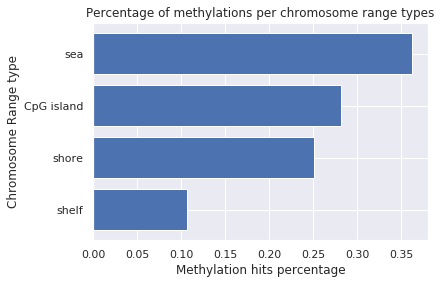

In [149]:
fig, ax = plt.subplots()
ax.barh(list(percentages.keys()), percentages.values())
ax.invert_yaxis()
ax.set_xlabel('Methylation hits percentage')
ax.set_ylabel('Chromosome Range type')
ax.set_title('Percentage of methylations per chromosome range types')

# TMP

In [141]:
import pandas as pd
pw_beds = pd.read_csv('../tmp/pawel-shelves.bed', sep='\t', header=None, names = ['chr', 'start', 'stop'])
rs_beds = pd.read_csv('./shelf.bed', sep='\t', header=None, names = ['chr', 'start', 'stop'])

In [142]:
pw_beds.start = pw_beds.start + 1

In [143]:
diffs = set(pw_beds.stop.values) - set(rs_beds.start.values)